## Predicting Properties of the 1d-TFIM from Classical shadows

In this notebook we will analyse the performance of the classical shadows in predicting
properties of our quantum system. We have a few objectives: $\\$
1.) Compare the predictions of the classical shadows with exact solution at different ratios
$\frac{h}{J}$ $\\$
2.) Determine how the relative error scales with the number of measurements $\\$
3.) Compare the randomized with the derandomized measurement approach $\\$
To simplify matters we only consider the antiferromagnetic case ($J=1$) with
periodic boundary conditions. $\\$
We start by computing hundreds of measurements for different numbers of qubits and ratios
$\frac{h}{J}$ and store them in a dictionary for later use since this is the most
computationally expensive part. Moreover, we can use the same measurements to
 predict different properties. We simulate our quantum system brute force and perform
measurements on the ground state which is computationally very expensive compared to
the remaining tasks for property prediction.

In [1]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../src'))
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.bf_quantum_state import BFQuantumState

In [2]:
#global variables
ratios_h_j = np.array([0.01, 0.02, 0.05, 0.1,
                           0.2, 0.5, 1.0, 2, 5, 10, 20, 50, 100], dtype=float)
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
save_direc_measurements_two_point_correlation_derandomized = Path('data/shadow_measurements/measurements_two_point_corr_derandomized_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()

In [16]:
qubit_num = np.array([6, 8, 10, 12])
# # the generation of a measurement procedure becomes very slow when num_of_measurements becomes big
# (~1000). In the case of the ising model it is alright to proceed by using batches because we only
# measure two different Pauli strings. We have to remove this batched procedure though when
# dealing with more complicated systems where we have to measure more than 100 different Pauli Strings
# for now we form batches of 100 measurements
# num of measurements has to be a multiple of 100
num_of_measurements = 1000000
measurement_methods = np.array(['derandomized', 'randomized'])
for i in range(np.size(qubit_num)):
    for j in range(np.size(ratios_h_j)):
        ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num[i])][str(ratios_h_j[j])]
        print('starting ratio h/J = ' + str(ratios_h_j[j]))
        for l in range(0, 2):
            observables = TfimHamiltonianOpenFermion(qubit_num[i], ratios_h_j[j], 1, 'periodic').observables_for_energy_estimation()
            measurement_procedure, measurement_index = BFQuantumState(qubit_num[i],
                                ground_state_dict[str(1)]['periodic'][str(qubit_num[i])][str(ratios_h_j[j])]).measurement_shadow(num_of_measurements,
                                                                                                                                    measurement_methods[l], observables)
            save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num[i])+'_method_'+measurement_methods[l]+'.npy')
            save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num[i])+'_method_'+measurement_methods[l]+'.npy')
            np.save(save_direc_procedure, measurement_procedure)
            np.save(save_direc_index, measurement_index)

starting ratio h/J = 1.0
starting ratio h/J = 1.0
starting ratio h/J = 1.0
starting ratio h/J = 1.0


### Comparison ground state energy: exact vs shadows
Now we compare the results achieved by our shadow method for the example of 1000
measurements with the exact solution for the ground state energy per qubit. We do this for both the
derandomized and the randomized measurement approach.

In [3]:
# load saved energy dict
energy_dict = np.load(save_direc_eigs, allow_pickle='TRUE')
energy_dict = energy_dict.item()

In [4]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

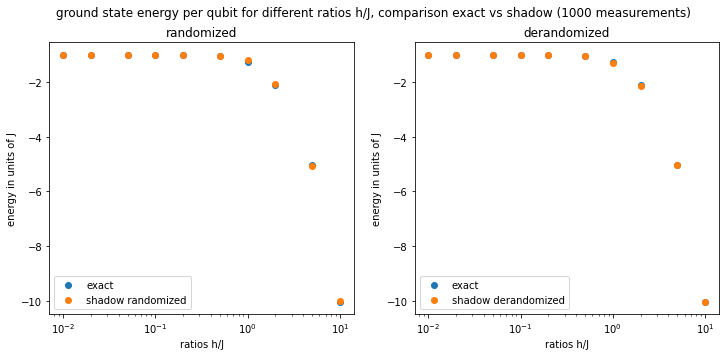

In [5]:
qubit_num = 14
num_of_measurements = 1000
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
fig.suptitle('ground state energy per qubit for different ratios h/J, comparison exact vs shadow (' + str(num_of_measurements) + ' measurements)')
measurement_methods = ['randomized', 'derandomized']
for i in range(0, 2):
    energy_shadow = np.zeros(np.size(ratios_h_j))
    energy_brute = np.zeros(np.size(ratios_h_j))
    for j in range(0, np.size(ratios_h_j)):
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[i]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[i]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[0:num_of_measurements,:],
                                                                  measurement_index[0:num_of_measurements], qubit_num)
        energy_shadow[j] = TfimHamiltonianOpenFermion(qubit_num, ratios_h_j[j],
                                             1, 'periodic').energy_shadow(None, num_of_measurements, measurement_methods[i], measurements)
        energy_brute[j] = energy_dict[str(1)]['periodic'][str(qubit_num)][str(ratios_h_j[j])][0]
    axs[i].scatter(ratios_h_j[:-3], energy_brute[:-3] / qubit_num, label = 'exact')
    axs[i].scatter(ratios_h_j[:-3], energy_shadow[:-3] / qubit_num, label = 'shadow ' + measurement_methods[i])
    axs[i].set(xscale='log', xlabel='ratios h/J',
                      ylabel='energy in units of J')
    axs[i].set_title(measurement_methods[i])
    axs[i].legend()

Now we plot the error in the ground state per qubit to see whether the shadows perform equally well for all values of
$\frac{h}{J}$. We plot both the relative and the absolute error. Since we are interested
in the mean error of 5000 measurements and not the error of this particular sample, we
split our $10^5$ measurements in 200 batches with 5000 measurements and compute the mean
error. Moreover, we compute the mean standard deviation according to the standard
formula:
\begin{equation}
\sigma^2 = \frac{1}{N} \sum_{i=1}^N (x_i - \mu)^2
\end{equation}


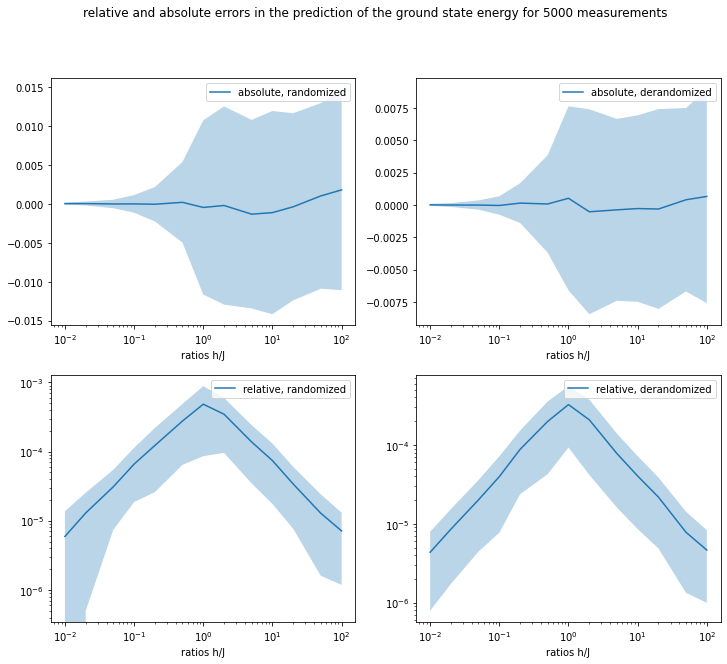

In [29]:
num_of_measurements = 5000
batches = 200
error_types = ['absolute', 'relative']
measurement_methods = ['randomized', 'derandomized']
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.suptitle('relative and absolute errors in the prediction of the ground state energy for ' + str(num_of_measurements) + ' measurements')

for i in range(0,2):
    for j in range(0,2):
        error = np.zeros((batches, np.size(ratios_h_j)))
        for b in range(0, batches):
            for k in range(0, np.size(ratios_h_j)):
                energy_brute = energy_dict[str(1)]['periodic'][str(qubit_num)][str(ratios_h_j[k])][0]
                save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(ratios_h_j[k])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[j]+'.npy')
                save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(ratios_h_j[k])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[j]+'.npy')
                measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
                measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[b*num_of_measurements:(b+1)*num_of_measurements,:],
                                                                          measurement_index[b*num_of_measurements:(b+1)*num_of_measurements], qubit_num)
                energy_shadow = TfimHamiltonianOpenFermion(qubit_num, ratios_h_j[k],
                                                 1, 'periodic').energy_shadow(None, num_of_measurements, measurement_methods[j], measurements)
                if error_types[i] == 'absolute':
                    error[b,k] = (energy_shadow - energy_brute) / qubit_num
                if error_types[i] == 'relative':
                    error[b,k] = np.abs(energy_brute - energy_shadow) / qubit_num / np.abs(energy_brute)
        error_mean = np.mean(error, axis = 0)
        error_std = np.std(error, axis = 0)
        axs[i, j].errorbar(ratios_h_j, error_mean, label = error_types[i] + ', ' + measurement_methods[j])
        axs[i, j].fill_between(ratios_h_j, error_mean - error_std, error_mean + error_std, alpha = 0.3)
        if error_types[i] == 'absolute':
            axs[i, j].set(xscale='log', xlabel='ratios h/J')
        if error_types[i] == 'relative':
            axs[i, j].set(xscale='log', yscale = 'log', xlabel='ratios h/J')
        axs[i, j].legend()

One can see that the accuracy is lowest in the region $\frac{h}{J} = 1$.

Now we want to see how the total error scales with the number of measurements
per observable. We focus on the relative error from now on.

We plot the average relative error per qubit number for different numbers of measurements
to see how the error scales.
We use 50 batches to compute the an accurate standard deviation of the prediction.

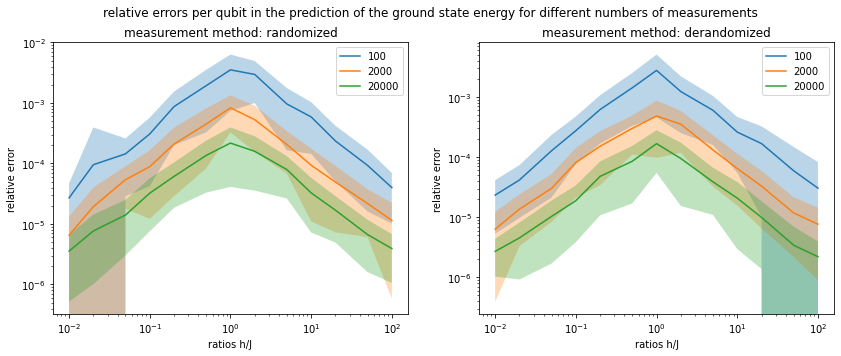

In [23]:
qubit_num = 14
num_of_measurements = np.array([100, 2000, 20000])
batches = 50
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative errors per qubit in the prediction of the ground state energy for different numbers of measurements')
errors = np.zeros((batches, np.size(ratios_h_j)))
for l in range(0, 2):
    for i in range(0, np.size(num_of_measurements)):
        for j in range(0, np.size(ratios_h_j)):
            energy_brute = energy_dict[str(1)]['periodic'][str(qubit_num)][str(ratios_h_j[j])][0]
            save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
            save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
            measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
            measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
            measurements_dict = conversion_to_prediction_shadow_dict_shape(measurement_procedure[0:batches * num_of_measurements[i]],
                                                                          measurement_index[0:batches * num_of_measurements[i]], qubit_num)
            for b in range(0, batches):
                measurements = measurements_dict[b*num_of_measurements[i]:(b+1)*num_of_measurements[i]]
                energy_shadow = TfimHamiltonianOpenFermion(qubit_num,
                                                           ratios_h_j[j], 1, 'periodic').energy_shadow(None,
                                                                                                       num_of_measurements[i],
                                                                                                       measurement_methods[l], measurements)
                errors[b,j] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute) / qubit_num
        error_mean = np.mean(errors, axis= 0)
        error_std = np.std(errors, axis = 0)
        axs[l].errorbar(ratios_h_j, error_mean, label = num_of_measurements[i])
        axs[l].fill_between(ratios_h_j, error_mean - error_std, error_mean + error_std, alpha = 0.3)
        axs[l].set(xscale='log', yscale='log', xlabel='ratios h/J', ylabel = 'relative error')
        axs[l].set_title('measurement method: ' + str(measurement_methods[l]))
        axs[l].legend()

The method of derandomized measurements converges faster than the randomized approach
but for big numbers of measurements (~1000) they first start performing equally well and
for $10^5$ measurements the randomized approach is equally good or maybe even better.
Now we plot the relative error against the number of samples for the three ratios
 $\frac{h}{J} \in \{0.1, 1, 10\}$. Again we calculate the mean and the standard deviation.

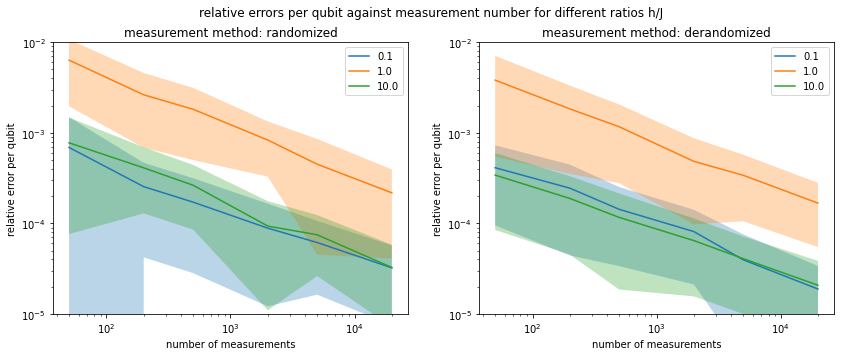

In [24]:
num_of_measurements = np.array([50, 200, 500, 2000, 5000, 20000])
batches = 50
some_ratios = np.array([0.1, 1, 10])
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative errors per qubit against measurement number for different ratios h/J')
for l in range(0, 2):
    for i in range(0, np.size(some_ratios)):
        energy_shadow = np.zeros(np.size(num_of_measurements))
        errors = np.zeros((batches, np.size(num_of_measurements)))
        energy_brute = energy_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios[i])][0] * np.ones(np.size(num_of_measurements))
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        for k in range(0, batches):
            for j in range(0, np.size(num_of_measurements)):
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]],
                                                                          measurement_index[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]], qubit_num)
                energy_shadow[j] = TfimHamiltonianOpenFermion(qubit_num,
                                                           some_ratios[i], 1, 'periodic').energy_shadow(None,
                                                                                                       num_of_measurements[j],
                                                                                                       measurement_methods[l], measurements)
            errors[k,:] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute) / qubit_num
        error_mean = np.mean(errors, axis=0)
        error_std = np.std(errors, axis=0)
        axs[l].errorbar(num_of_measurements, error_mean, label = some_ratios[i])
        axs[l].fill_between(num_of_measurements, error_mean - error_std, error_mean + error_std, alpha = 0.3)
        axs[l].set_ylim([1e-5, 1e-2])
        axs[l].set(xscale='log', yscale='log', xlabel='number of measurements', ylabel = 'relative error per qubit')
        axs[l].set_title('measurement method: ' + str(measurement_methods[l]))
        axs[l].legend()

We can see that the scaling of the error is approximately equally fast for all ratios. The
ratio $\frac{h}{J} = 1$ however provides the lowest accuracy. This makes sense because
this is the only region where the expectation values of $\langle Z_i Z_{i+1} \rangle$ and
$X_i$ are equally important and both contribute in a relevant manner to the uncertainty.

Now we fix the error and determine the number of samples needed to achieve it. We plot this
against the different ratios $\frac{h}{J}$. We choose the three different relative errors
$10^{-2}, 10^{-3}, 10^{-4}$. We compute mean and standard deviation using 50 batches.
We only say that a certain accuracy is reached if all later estimates using more samples also reach this accuracy.
This way we avoid cases where the error fluctuated below the error threshold but starts increasing again afterwards.

In [30]:
fixed_errors = np.array([1e-2, 1e-3, 1e-4])
batches = 50
sample_size_intervals = np.append(np.arange(1, 20, 1),np.append(np.arange(20, 200, 10), np.append(np.arange(200, 2000, 100), np.arange(2000, 20000, 500))))
error_mean = np.zeros((np.size(sample_size_intervals), np.size(measurement_methods), np.size(ratios_h_j)))
error_std = np.zeros((np.size(sample_size_intervals), np.size(measurement_methods), np.size(ratios_h_j)))
error_list = np.zeros((batches, np.size(sample_size_intervals), np.size(measurement_methods), np.size(ratios_h_j)))
for l in range(0, 2):
    for i in range(0, np.size(ratios_h_j)):
        energy_shadow = np.zeros(np.size(sample_size_intervals))
        energy_brute = energy_dict[str(1)]['periodic'][str(qubit_num)][str(ratios_h_j[i])][0] * np.ones(np.size(sample_size_intervals))
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(ratios_h_j[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(ratios_h_j[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        for k in range(0, batches):
            for j in range(0, np.size(sample_size_intervals)):
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*sample_size_intervals[j]:(k+1)*sample_size_intervals[j]],
                                                                          measurement_index[k*sample_size_intervals[j]:(k+1)*sample_size_intervals[j]], qubit_num)
                energy_shadow[j] = TfimHamiltonianOpenFermion(qubit_num,
                                                           ratios_h_j[i], 1, 'periodic').energy_shadow(None,
                                                                                                       sample_size_intervals[j],
                                                                                                       measurement_methods[l], measurements)
                error_list[k,:,l,i] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute) / qubit_num

save_direc_error_list = Path('data/shadow_measurements/error_list.npy')
np.save(save_direc_error_list, error_list)

In [6]:
save_direc_error_list = Path('data/shadow_measurements/error_list.npy')
error_list = np.load(save_direc_error_list, allow_pickle='TRUE')

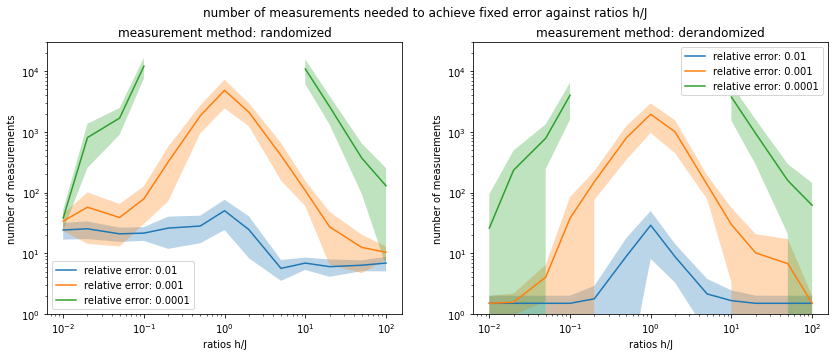

In [23]:
fixed_errors = np.array([1e-2, 1e-3, 1e-4])
batches = 50
sample_size_intervals = np.append(np.arange(1, 20, 1),np.append(np.arange(20, 200, 10), np.append(np.arange(200, 2000, 100), np.arange(2000, 20000, 500))))
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('number of measurements needed to achieve fixed error against ratios h/J')

for l in range(0,2):
    for e in range(0, np.size(fixed_errors)):
        sample_size = np.zeros((batches, np.size(ratios_h_j)))
        for i in range(0, np.size(ratios_h_j)):
            for k in range(0, batches):
                pos = np.where(error_list[k,:,l,i] <= fixed_errors[e])[0]
                if pos.size == 0:
                    sample_size[k,i] = None
                else:
                    for p in range(0, pos.size):
                        if pos.size - p == np.size(sample_size_intervals[pos[p]:]):
                            sample_size[k,i] = sample_size_intervals[pos[p]]
                            break
                        if p == pos.size - 1:
                            sample_size[k,i] = None
        sample_size_mean = np.mean(sample_size, axis=0)
        sample_size_std = np.std(sample_size, axis=0)
        for rat in range(0, np.size(ratios_h_j)):
            for bat in range(0, batches):
               if sample_size[bat, rat] is None:
                    sample_size_mean[rat] = None
                    sample_size_std[rat] = None
        axs[l].errorbar(ratios_h_j, sample_size_mean, label = 'relative error: ' + str(fixed_errors[e]))
        axs[l].fill_between(ratios_h_j, sample_size_mean - sample_size_std, sample_size_mean + sample_size_std, alpha = 0.3)
        axs[l].legend()
        axs[l].set_ylim([1, 3*10**4])
        axs[l].set_title('measurement method: ' + str(measurement_methods[l]))
        axs[l].set(xscale='log', yscale='log', xlabel='ratios h/J', ylabel = 'number of measurements')


We can clearly see that more and more samples are needed the closer one gets to $\frac{h}{J} = 1$.

The classical shadow paper by Huang et al gives rigorous performance guarantees for the shadow
protocol. Now we will compare the predicted scaling of the error with the number of measurements
with the actual scaling in these numerical experiments.

$\textbf{Theorem 1}$
Suppose $\textbf{U} = Cl(2)^{\otimes n}$ and the k-local observables $O_i$ consist
 of tensor products of Pauli matrices of which at most k are not the identity.
  Then N classical shadows $\hat{\rho}$ suffice to predict the expectation values $\hat{o}_i$
   of M observables $\{Tr{O_1 \rho}, \ldots Tr{O_M \rho}\}$ with
probability $1 - \delta$ and accuracy $\epsilon$ if
\begin{equation}
N \geq \mathcal{O}\biggl(\frac{\log(M/\delta)}{\epsilon^2} 3^k \biggr)
\end{equation}

The accuracy $\epsilon$ is then an upper error bound:
\begin{equation}
(Tr{(O_i \rho)} - \hat{o}_i )< \epsilon \forall O_i
\end{equation}

From the basic information theoretic considerations in the shadow paper we know that
in the worst case scenario
this is not only an upper boundary on the number of measurements $N$ neeeded but also
a lower boundary. In a best case-scenario the performance could also be better though.

The rigorous performance guarantee for the scaling of our shadows states
that $N = \mathcal{O}(\frac{1}{\epsilon^2})$. We would like to see
how the accuracy scales in our experiment . It must perform
   at least as good as the performance guarantee states. We assume
a scaling of the form  $N = \frac{C}{\epsilon^a}$ where we want to
 determine $C$ and $a$ by least square fits for all ratios $\frac{h}{J}$.
At $\frac{h}{J} = 1$ a quantum phase transition happens. Speaking roughly, it
becomes difficult / takes a lot of measurements to predict properties of the
corresponding quantum ground state. We are close to a 'worst-case-scenario'.
Hence, it is reasonable to assume a scaling of the form $N = \frac{C}{\epsilon^a}$
in this region. Further away from $\frac{h}{J} = 1$ this relationship might break.
Taking the $\log$ on both sides gives:
$ \log{N} = \log{C} - a \log{\epsilon}$.
We can make a fit to determine $a$ and $\log{C}$. Then we have a relationship between
$N$ and $\epsilon$. We can use this relationship to determine the error in $N$.

\begin{equation}
\Delta N = \frac{C a}{\epsilon^{a+1}}\Delta \epsilon
\end{equation}

We get the error $\Delta \log{C}$ as fit result
but want $\Delta C$. We can compute $\Delta C$ using Gaussian error
propagation. $\Delta \log{C} = \frac{\Delta C}{C} \rightarrow
 \Delta C = C \Delta \log{C}$.

$\epsilon$ is given by:

\begin{equation}
\epsilon = \max_i (Tr(O_i \rho) - \hat{o}_i)
\end{equation}

We determine the averaged $\epsilon$
and its standard deviation by using 50 measurement batches.
If we just compute the error there is a complication.
Complication: We add up the predictions for the $2n$ local observables in the
Hamiltonian. This way errors start to average out (one term is too small, another term
is too big).
Thus, we have to compute the expectation values of all $M=2n$ observables individually and
add the absolute values of the errors. This way they do not average out. It does not make
sense to take the relative error because the observables could be close to zero and thus the relative
error could become very big.

In [7]:
from scipy.optimize import curve_fit
def log_epsilon(num_measurements_log, const_log, exponent):
    return (const_log - num_measurements_log)/exponent


def log_n(error_log, const_log, exponent):
    return const_log - exponent * error_log

from scipy.stats import chi2

def compute_p_value_and_chi_red(data_x, data_y, params, data_y_std):
    chi2_sum = np.sum((np.exp(log_n(np.log(data_x), params[0], params[1])) - data_y)**2/ data_y_std**2)
    dof = np.size(num_of_measurements) - 2
    chi2_red = chi2_sum / dof
    p_val = round(1 - chi2.cdf(chi2_sum, dof),2)*100
    return  p_val, chi2_red

randomized measurements, const = 13.755718165434045 +- 0.5289391343974367
randomized measurements, exponent = 2.036502006263449 +- 0.01735804897943978
randomized measurements, p_val = 100.0, chi_red = 0.011170038505644178
randomized measurements, const = 24.603129198736166 +- 1.2381743085767816
randomized measurements, exponent = 1.9689334979123363 +- 0.02487692838526013
randomized measurements, p_val = 100.0, chi_red = 0.0245797497093338
derandomized measurements, const = 4.476699690490132 +- 0.2758378849785913
derandomized measurements, exponent = 2.0095533384406674 +- 0.02226829496781362
derandomized measurements, p_val = 100.0, chi_red = 0.022975840067279825
derandomized measurements, const = 6.378753744857896 +- 0.23033980244043636
derandomized measurements, exponent = 1.9886688897906972 +- 0.013739989651850602
derandomized measurements, p_val = 100.0, chi_red = 0.016480490667611158


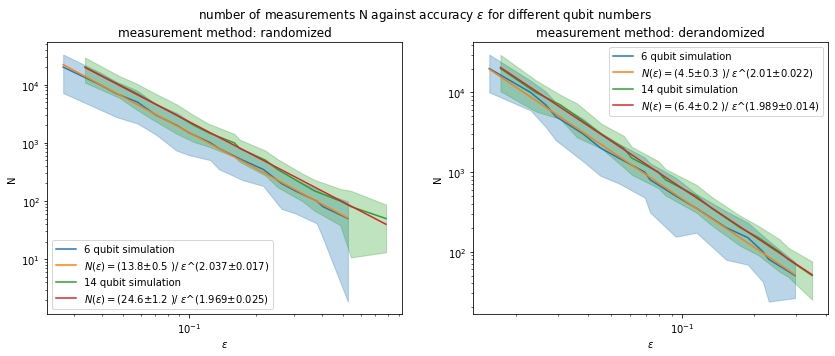

In [20]:
qubit_nums = np.array([6, 14])
num_of_measurements = np.array([50, 80, 100, 150, 200, 350, 500, 800, 1000, 1500, 2000, 3000, 5000, 7000, 10000, 20000])
batches = 50
some_ratios = np.array([1.0])
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('number of measurements N against accuracy $\epsilon$ for different qubit numbers')
for l in range(0, 2):
    for qubit_num in qubit_nums:
        for i in range(0, np.size(some_ratios)):
            errors = np.zeros((batches, np.size(num_of_measurements)))
            ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios[i])]
            observables = TfimHamiltonianOpenFermion(qubit_num, 1, some_ratios[i], 'periodic').observables_for_energy_estimation()
            save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                                  str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
            save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                                  str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
            measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
            measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
            for k in range(0, batches):
                for j in range(0, np.size(num_of_measurements)):
                    measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]],
                                                                              measurement_index[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]], qubit_num)
                    errors_one_batch = []
                    for observable in observables:
                        exp_val_obs_shadow = BFQuantumState(qubit_num, ground_state).local_observable_shadow(observable, measurements)
                        exp_val_obs_brute = BFQuantumState(qubit_num, ground_state).local_observable(observable)
                        errors_one_batch.append(np.abs(exp_val_obs_brute - exp_val_obs_shadow))
                    errors[k, j] = np.amax(errors_one_batch, axis = 0)

            error_mean = np.mean(errors, axis=0)
            error_std = np.std(errors, axis=0)
            popt, pcov = curve_fit(log_n, np.log(error_mean), np.log(num_of_measurements))
            print(measurement_methods[l] + ' measurements, const = ' + str(np.exp(popt[0])) + ' +- ' + str(np.exp(popt[0]) * np.sqrt(pcov[0][0])))
            print(measurement_methods[l] + ' measurements, exponent = ' + str(popt[1]) + ' +- ' + str(np.sqrt(pcov[1][1])))
            num_of_measurements_std = np.exp(popt[0]) * popt[1] / (error_mean ** (popt[1] + 1)) * error_std
            p_val, chi_red = compute_p_value_and_chi_red(error_mean, num_of_measurements, popt, num_of_measurements_std)
            print(measurement_methods[l] + ' measurements, p_val = ' + str(p_val) + ', chi_red = ' + str(chi_red))
            axs[l].errorbar(error_mean, num_of_measurements, label = str(qubit_num) + ' qubit simulation')
            axs[l].fill_between(error_mean, num_of_measurements - num_of_measurements_std, num_of_measurements + num_of_measurements_std, alpha = 0.3,
                                color = 'C' + str(int(2) * int(np.where(qubit_nums == qubit_num)[0])))
            axs[l].errorbar(error_mean, np.exp(log_n(np.log(error_mean),popt[0], popt[1])),
                            label='$N(\epsilon) = ($' + str(np.round(np.exp(popt[0]),1)) + '$ \pm $' + str(np.round(np.exp(popt[0]) * np.sqrt(pcov[0][0]),1))+ ' )/ $\epsilon$^(' + str(np.round(popt[1],3)) + '$ \pm $' + str(np.round(np.sqrt(pcov[1][1]),3)) + ')' )
            axs[l].set(xscale='log', yscale='log', ylabel='N', xlabel = '$\epsilon$')
            axs[l].set_title('measurement method: ' + str(measurement_methods[l]))
            axs[l].legend()

In [19]:
a = np.arange(10)
int(np.where(a == 5)[0])

5

This shows that both the randomized and derandomized approach have approximately
the same $\epsilon$. The
derandomized measurements just start of with a smaller constant. Yet, the formula we
gave for the
performance guarantee of the randomized classical shadows might not be valid for the
derandomized classical shadows. We investigate this by doing
a statistical hypothesis test to see whether the fitting function really
describes the data well. We use the $\chi^2$ distribution to compute the p-value. The
p-value describes the probability to obtain a higher $\chi^2$ value if one performs the
measurement again. Thus, ideally $p=0.5$ .

 $\chi^2$ is given by:

\begin{equation}
\chi ^2 = \sum_{i=1}^{d} \frac{(N_i - \hat{N}(\epsilon_i,C,a))^2}{\sigma_i^2}
\end{equation}

where $d$ is the number of datapoints, $\hat{\epsilon}(N,C,a)$ our fitfunction with the
ideal values we just found, the $\epsilon_i$ are our datapoints / mean errors and the $\sigma_i$
are the standard deviations of the $\epsilon_i$ datapoints.

In both cases we obtain p-values of 100% which means that we either drastically overfit
or that the standard deviation we computed is way too big. The later might be the case
because the standard deviation keeps becoming smaller the more batches we use to
determine it.

Now we would like to compute this for every ratio $\frac{h}{J}$ and plot both the
constant $C$ and the exponent $a$ against the different ratios $\frac{h}{J}$.

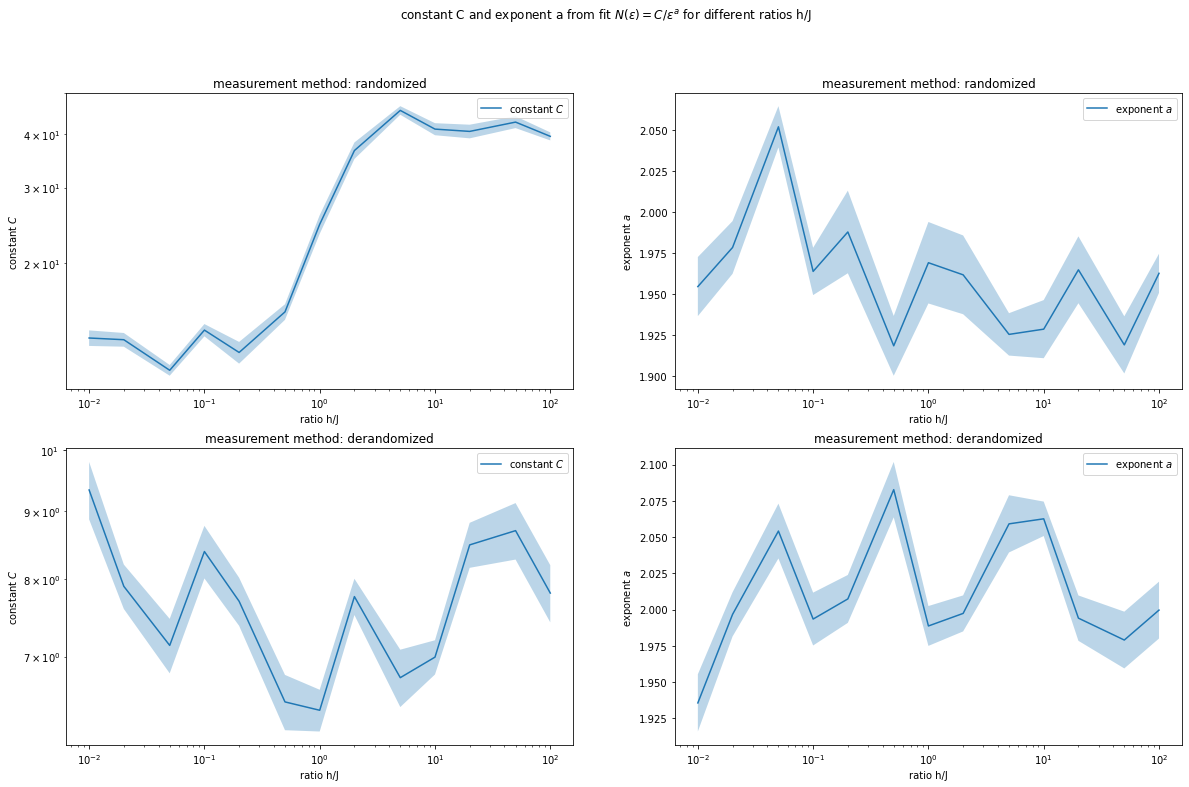

In [19]:
qubit_num = 14
num_of_measurements = np.array([50, 80, 100, 150, 200, 350, 500, 800, 1000, 1500, 2000, 3000, 5000, 7000, 10000, 20000])
batches = 50
some_ratios = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100])
fig, axs = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(20)
fig.suptitle('constant C and exponent a from fit $N(\epsilon) = C/\epsilon^a$ for different ratios h/J')
for l in range(0, 2):
    exponents = np.zeros(np.size(some_ratios))
    constants = np.zeros(np.size(some_ratios))
    exponents_err = np.zeros(np.size(some_ratios))
    constants_err = np.zeros(np.size(some_ratios))
    for i in range(0, np.size(some_ratios)):
        errors = np.zeros((batches, np.size(num_of_measurements)))
        ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios[i])]
        observables = TfimHamiltonianOpenFermion(qubit_num, 1, some_ratios[i], 'periodic').observables_for_energy_estimation()
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        for k in range(0, batches):
            for j in range(0, np.size(num_of_measurements)):
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]],
                                                                          measurement_index[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]], qubit_num)
                errors_one_batch = []
                for observable in observables:
                    exp_val_obs_shadow = BFQuantumState(qubit_num, ground_state).local_observable_shadow(observable, measurements)
                    exp_val_obs_brute = BFQuantumState(qubit_num, ground_state).local_observable(observable)
                    errors_one_batch.append(np.abs(exp_val_obs_brute - exp_val_obs_shadow))
                errors[k, j] = np.amax(errors_one_batch, axis = 0)

        error_mean = np.mean(errors, axis=0)
        error_std = np.std(errors, axis=0)
        popt, pcov = curve_fit(log_n, np.log(error_mean), np.log(num_of_measurements))
        constants[i] = np.exp(popt[0])
        constants_err[i] = np.exp(popt[0]) * np.sqrt(pcov[0][0])
        exponents[i] = popt[1]
        exponents_err[i] = np.sqrt(pcov[1][1])
    axs[l, 0].errorbar(some_ratios, constants, label = 'constant $C$')
    axs[l, 0].fill_between(some_ratios, constants - constants_err, constants + constants_err, alpha = 0.3)
    axs[l, 0].set(xscale='log', yscale='log', ylabel='constant $C$', xlabel = 'ratio h/J')
    axs[l, 0].set_title('measurement method: ' + str(measurement_methods[l]))
    axs[l, 0].legend()
    axs[l, 1].errorbar(some_ratios, exponents, label = 'exponent $a$')
    axs[l, 1].fill_between(some_ratios, exponents - exponents_err, exponents + exponents_err, alpha = 0.3)
    axs[l, 1].set(xscale='log', ylabel='exponent $a$', xlabel = 'ratio h/J')
    axs[l, 1].set_title('measurement method: ' + str(measurement_methods[l]))
    axs[l, 1].legend()

We can see that $\epsilon \approx 2$ for both cases.


1. Complication: We add up the predictions for the $2n$ local observables in the
Hamiltonian. This way errors start to average out (one term is too small, another term
is too big).
2. Complication: The proof in the shadow paper that shows the relationship
$N = \mathcal{O}(\frac{1}{\epsilon^2})$ assumes the use of a median of means
algorithm in the feature prediction. --> No problem because when looking into the
proof the relationship also holds when just using the empirical mean.

#### Scaling of the classical shadwos with $\log{(M)}$

Rigorous performance guarantee:

\begin{equation}
N = \mathcal{O}(\frac{\log{M}}{\epsilon^2})
\end{equation}

It is much easier to compute $\epsilon$ for a fixed number of measurements $N$.
We just do a fit to the function:

\begin{equation}
N = \frac{C_{fit}}{\epsilon^a}
\end{equation}

where $C_{fit} = C \log{M}$. If we find $C_{fit}$ and $a$ for different $M$ we can plot
$N(M)$ for fixed $\epsilon$ simply by using the relationship $N(\epsilon, M)$ above.
We can compute the error in $N$ from the error in $C$ and $a$.

\begin{equation}
\Delta N = \sqrt{(\frac{\Delta C}{\epsilon^a})^2 +
 (\frac{C \log{\frac{1}{\epsilon}}}{\epsilon^a} \Delta a)^2}
\end{equation}

To enable a fair comparison we keep the number of qubits even because
the system should then inhibit roughly the same properties. We know that $M = 2n$. We use the
ratio $\frac{h}{J} = 1$.
If we just compute the error there is a complication.
Complication: We add up the predictions for the $2n$ local observables in the
Hamiltonian. This way errors start to average out (one term is too small, another term
is too big).
Thus, we have to compute the expectation values of all $M=2n$ observables individually and
add the absolute values of the errors. This way they do not average out. It does not make
sense to take the relative error because the observables could be close to zero and thus the relative
error could become very big.

In [21]:
from scipy.optimize import curve_fit

def n_of_m(log_m, constant):
    return constant * log_m


randomized measurements, const = 16.04147693158565 +- 0.45823605617988133
randomized measurements, exponent = 1.9734224895292287 +- 0.01349164622973025
randomized measurements, const = 18.484672007586454 +- 0.7164148285259015
randomized measurements, exponent = 1.9805240192486846 +- 0.018969450672056385
randomized measurements, const = 20.930410853042947 +- 0.4304920491905709
randomized measurements, exponent = 1.966928335226583 +- 0.01028937694722738
randomized measurements, const = 23.476911147516144 +- 0.7977421969932164
randomized measurements, exponent = 1.9603417999309356 +- 0.017410327072864763
randomized measurements, const = 25.770402598981654 +- 0.9000522260870729
randomized measurements, exponent = 1.9330406324464642 +- 0.01804850608793852
constant = 164.40723073315786  +-  3.3523317001739192
randomized measurements, const = 16.04147693158565 +- 0.45823605617988133
randomized measurements, exponent = 1.9734224895292287 +- 0.01349164622973025
randomized measurements, const = 

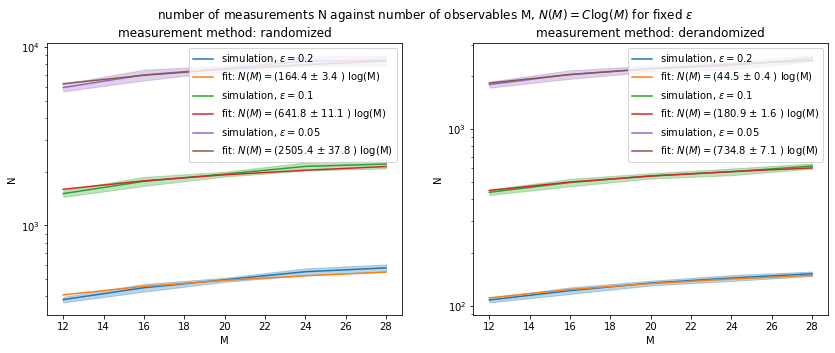

In [22]:
qubit_nums = np.array([6, 8, 10, 12, 14])
fixed_errors = np.array([0.2, 0.1, 0.05])
num_of_measurements = np.array([50, 100, 200, 500, 1000, 1500, 2000, 3000, 4000, 5000])
batches = 200
some_ratios = np.array([1.0])
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('number of measurements N against number of observables M, $N(M) = C \log(M)$ for fixed $\epsilon$')
for l in range(0, 2):
    for fixed_error in fixed_errors:
        meas_num = np.zeros(np.size(qubit_nums))
        meas_num_std = np.zeros(np.size(qubit_nums))
        for q in range(np.size(qubit_nums)):
            for i in range(0, np.size(some_ratios)):
                errors = np.zeros((batches, np.size(num_of_measurements)))
                ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_nums[q])][str(some_ratios[i])]
                observables = TfimHamiltonianOpenFermion(qubit_nums[q], 1, some_ratios[i], 'periodic').observables_for_energy_estimation()
                save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                                      str(some_ratios[i])+'_qubit_num_'+str(qubit_nums[q])+'_method_'+measurement_methods[l]+'.npy')
                save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                                      str(some_ratios[i])+'_qubit_num_'+str(qubit_nums[q])+'_method_'+measurement_methods[l]+'.npy')
                measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
                measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
                for k in range(0, batches):
                    for j in range(0, np.size(num_of_measurements)):
                        measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]],
                                                                                  measurement_index[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]], qubit_nums[q])
                        errors_one_batch = []
                        for observable in observables:
                            exp_val_obs_shadow = BFQuantumState(qubit_nums[q], ground_state).local_observable_shadow(observable, measurements)
                            exp_val_obs_brute = BFQuantumState(qubit_nums[q], ground_state).local_observable(observable)
                            errors_one_batch.append(np.abs(exp_val_obs_brute - exp_val_obs_shadow))
                        errors[k, j] = np.amax(errors_one_batch, axis = 0)

                error_mean = np.mean(errors, axis=0)
                error_std = np.std(errors, axis=0)
                popt, pcov = curve_fit(log_n, np.log(error_mean), np.log(num_of_measurements))
                print(measurement_methods[l] + ' measurements, const = ' + str(np.exp(popt[0])) + ' +- ' + str(np.exp(popt[0]) * np.sqrt(pcov[0][0])))
                print(measurement_methods[l] + ' measurements, exponent = ' + str(popt[1]) + ' +- ' + str(np.sqrt(pcov[1][1])))
                meas_num[q] = np.exp(popt[0]) / fixed_error ** popt[1]
                meas_num_std[q] = np.sqrt((np.exp(popt[0]) * np.sqrt(pcov[0][0]) / fixed_error ** popt[1])**2 +
                                          (np.exp(popt[0]) * np.log(1/fixed_error) / fixed_error ** popt[1] * np.sqrt(pcov[1][1]))**2)
        popt, pcov = curve_fit(n_of_m, np.log(qubit_nums * 2), meas_num, sigma= meas_num_std)
        print('constant = ' + str(popt[0]) , ' +- ', str(np.sqrt(pcov[0][0])))
        axs[l].errorbar(qubit_nums * 2, meas_num, label = 'simulation, $\epsilon = $' + str(fixed_error))
        axs[l].fill_between(qubit_nums * 2, meas_num - meas_num_std, meas_num + meas_num_std, alpha = 0.3,
                            color = 'C' + str(int(2) * int(np.where(fixed_errors == fixed_error)[0])))
        axs[l].errorbar(qubit_nums * 2, n_of_m(np.log(qubit_nums * 2), popt[0]),
                        label='fit: $N(M) = ($' + str(np.round(popt[0],1)) + ' $\pm$ ' + str(np.round(np.sqrt(pcov[0][0]),1)) + ' ) log(M)')
        axs[l].set(yscale = 'log', ylabel='N', xlabel = 'M')
        axs[l].set_title('measurement method: ' + str(measurement_methods[l]))
        axs[l].legend()

### Comparison Two Point Correlation: shadows vs exact
Now we compute the Two Point Correlation and compare the values computed with the shadows with
the exact values. We compute the Two Point Correlation in the Z basis. It is given by
$\langle \Psi_0 | \sigma_0^z \sigma_i^z |\Psi_0 \rangle$ . We compute the prediction for
1000 measurements and calculate again standard deviation and mean by considering
100 batches of 1000 measurements.
We will only consider the randomized case at first since for this case we can just reuse the
random measurements we already did.

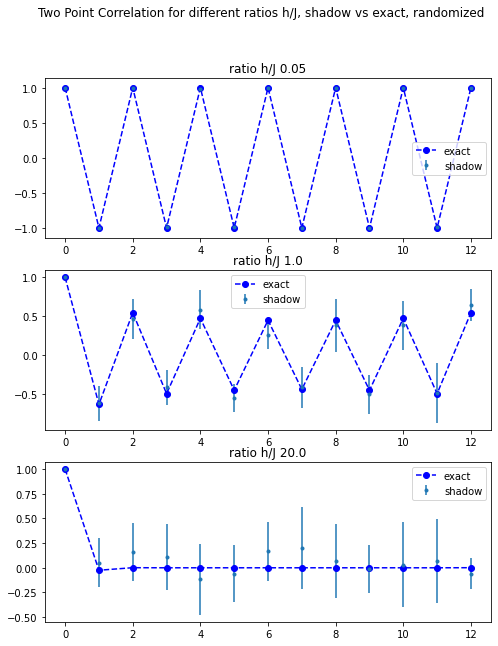

In [43]:
qubit_num = 14
num_of_measurements = 100
batches = 10
some_ratios_h_j = np.array([0.05, 1.0, 20.0])
dist = np.arange(0, qubit_num - 1, 1)
fig, axs = plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(8)
fig.suptitle('Two Point Correlation for different ratios h/J, shadow vs exact, randomized')
for j in range(0, np.size(some_ratios_h_j)):
    correlation_shadow = np.zeros((batches, qubit_num - 1))
    correlation_brute = np.zeros(qubit_num - 1)
    for b in range(0, batches):
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(some_ratios[j])+'_qubit_num_'+str(qubit_num)+'_method_randomized.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(some_ratios[j])+'_qubit_num_'+str(qubit_num)+'_method_randomized.npy')
        measurement_procedure = np.load(save_direc_procedure, allow_pickle='TRUE')
        measurement_index = np.load(save_direc_index, allow_pickle='TRUE')
        measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure,
                                                                          measurement_index, qubit_num)[b*num_of_measurements:(b+1)*num_of_measurements]
        for i in range(0, qubit_num - 1):
            correlation_shadow[b,i] = BFQuantumState(qubit_num, None).two_point_correlation_shadow(num_of_measurements, measurements, 'randomized', i, 'Z')
            ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[j])]
            correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
    corr_shadow_mean = np.mean(correlation_shadow, axis = 0)
    corr_shadow_std = np.std(correlation_shadow, axis=0)
    axs[j].errorbar(dist, corr_shadow_mean, yerr = corr_shadow_std,  label = 'shadow', fmt = '.')
    axs[j].plot(dist, correlation_brute, 'bo', linestyle = 'dashed', label = 'exact')
    axs[j].legend()
    axs[j].set_title('ratio h/J ' + str(some_ratios_h_j[j]))

The predictions fit the exact values very well. Now we would like to see how
the prediction accuracy improves with more measurements. We focus on the case $\frac{h}{J}=1$
and compute the absolute error.

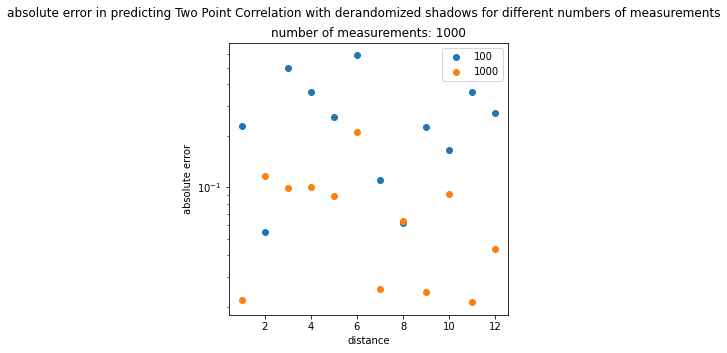

In [44]:
some_ratios_h_j = np.array([1.0])
num_of_measurements = np.array([100, 1000])
dist = np.arange(0, qubit_num - 1, 1)
fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(5)
fig.suptitle('absolute error in predicting Two Point Correlation with derandomized shadows for different numbers of measurements')
for l in range(0, np.size(some_ratios_h_j)):
    for j in range(0, np.size(num_of_measurements)):
        correlation_brute = np.zeros(qubit_num - 1)
        correlation_shadow = np.zeros(qubit_num - 1)
        for i in range(0, qubit_num - 1):
            ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[l])]
            save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(some_ratios_h_j[l])+'_qubit_num_'+str(qubit_num)+'_method_randomized.npy')
            save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(some_ratios_h_j[l])+'_qubit_num_'+str(qubit_num)+'_method_randomized.npy')
            measurement_procedure = np.load(save_direc_procedure, allow_pickle='TRUE')
            measurement_index = np.load(save_direc_index, allow_pickle='TRUE')
            measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure,
                                                                          measurement_index, qubit_num)[0:num_of_measurements[j]]
            correlation_shadow[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation_shadow(num_of_measurements, measurements , 'randomized', i, 'Z')
            correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
        errors = np.abs(correlation_brute - correlation_shadow)
        axs.scatter(dist[1:], errors[1:], label = num_of_measurements[j])
        axs.set_title('number of measurements: ' + str(num_of_measurements[j]))
        axs.set(xlabel='distance', ylabel = 'absolute error', yscale = 'log')
        axs.legend()


We can see that the prediction accuracy continues to improve all the way up to $10^5$
measurements.
Now we will investigate the performance of the
derandomized method for the three cases and then we will check again the convergence of
the error.



When estimating the Two Point correlations for different distances and one ratio $\frac{h}{J}$
we have to estimate the observables $\{Z_0Z_0, Z_0Z_1, \ldots ,Z_0Z_n \}$ where $n$ is the
number of qubits. Hence, the derandomization procedure simply tells us to measure the string
$Z_0 Z_1 \ldots Z_N$ over and over again. This has already been done in the energy estimation
part. Here the derandomization procedure told to measure the strings $Z_0 Z_1 \ldots Z_N$
and $X_0 X_1 \ldots X_N$ over and over again. Thus, we do not have to do the measurement twice and
can simply extract the desired measurements by using every second measurement in the
derandomized measurement file.

We determine the mean and standard deviation by splitting the 50000 measurements in
50 batches of size 1000. From the individual results we compute standard deviation
and mean.


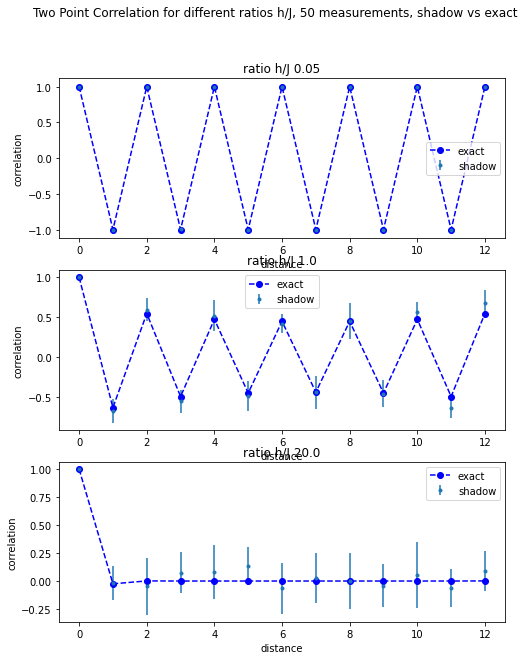

In [46]:
num_of_measurements = 50
batches = 10
some_ratios_h_j = np.array([0.05, 1.0, 20.0])
dist = np.arange(0, qubit_num - 1, 1)
fig, axs = plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(8)
fig.suptitle('Two Point Correlation for different ratios h/J, ' + str(num_of_measurements) + ' measurements, shadow vs exact')
index_filter = np.arange(1, num_of_measurements, 2)
for j in range(0, np.size(some_ratios_h_j)):
    correlation_shadow = np.zeros((batches, qubit_num - 1))
    correlation_brute = np.zeros(qubit_num - 1)
    ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[j])]
    save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(some_ratios_h_j[j])+'_qubit_num_'+str(qubit_num)+'_method_derandomized.npy')
    save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(some_ratios_h_j[j])+'_qubit_num_'+str(qubit_num)+'_method_derandomized.npy')
    measurement_procedure = np.load(save_direc_procedure, allow_pickle='TRUE')
    measurement_index = np.load(save_direc_index, allow_pickle='TRUE')
    for b in range(0, batches):
        for i in range(0, qubit_num - 1):
            measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure,
                                                                          measurement_index, qubit_num)[b*num_of_measurements*2:(b+1)*num_of_measurements*2]
            measurement_filtered = []
            for l in range(0, np.size(index_filter)):
                measurement_filtered.append(measurements[index_filter[l]])
            correlation_shadow[b,i] = BFQuantumState(qubit_num, ground_state).two_point_correlation_shadow(num_of_measurements, measurement_filtered , 'derandomized', i, 'Z')
            correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
    corr_shadow_mean = np.mean(correlation_shadow, axis=0)
    corr_shadow_std = np.std(correlation_shadow, axis=0)
    axs[j].errorbar(dist, corr_shadow_mean, yerr = corr_shadow_std, label = 'shadow', fmt='.')
    axs[j].plot(dist, correlation_brute, 'bo', linestyle = 'dashed', label = 'exact')
    axs[j].legend()
    axs[j].set_title('ratio h/J ' + str(some_ratios_h_j[j]))
    axs[j].set(xlabel = 'distance', ylabel = 'correlation')



From now on we focus on the ratio $\frac{h}{J} = 1$ where the phase transition happens
since this is the most interesting area. For this value we investigate how the prediction
accuracy of the shadows scales with the number of measurements.
We compute the absolute error at every distance. We make error plots for different
numbers of measurements and see how the prediction accuracy improves.

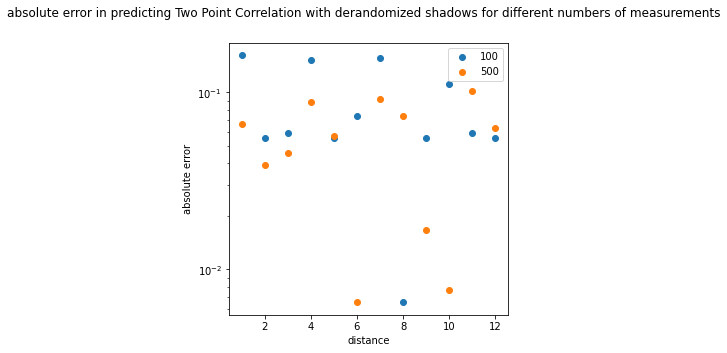

In [49]:
some_ratios_h_j = np.array([1.0])
num_of_measurements = np.array([100, 500])
dist = np.arange(0, qubit_num - 1, 1)
fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(5)
fig.suptitle('absolute error in predicting Two Point Correlation with derandomized shadows for different numbers of measurements')
for l in range(0, np.size(some_ratios_h_j)):
    save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(some_ratios_h_j[l])+'_qubit_num_'+str(qubit_num)+'_method_derandomized.npy')
    save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(some_ratios_h_j[l])+'_qubit_num_'+str(qubit_num)+'_method_derandomized.npy')
    measurement_procedure = np.load(save_direc_procedure, allow_pickle='TRUE')
    measurement_index = np.load(save_direc_index, allow_pickle='TRUE')
    for j in range(0, np.size(num_of_measurements)):
        index_filter = np.arange(1, num_of_measurements[j], 2)
        correlation_brute = np.zeros(qubit_num - 1)
        correlation_shadow = np.zeros(qubit_num - 1)
        for i in range(0, qubit_num - 1):
            ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[l])]
            measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure,
                                                                          measurement_index, qubit_num)[0:num_of_measurements[j]]
            measurement_filtered = []
            for m in range(0, np.size(index_filter)):
                measurement_filtered.append(measurements[index_filter[m]])
            correlation_shadow[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation_shadow(num_of_measurements, measurement_filtered, 'derandomized', i, 'Z')
            correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
        errors = np.abs(correlation_brute - correlation_shadow)
        axs.scatter(dist[1:], errors[1:], label = str(num_of_measurements[j]))
    axs.legend()
    axs.set(xlabel='distance', ylabel = 'absolute error', yscale = 'log')

The error keeps converging all the way up to 50000 measurements. The accuracy obtained
is twice as good as for randomized measurements with half as many measurements. One can
see that the accuracy decreases with the distance.
